In [1]:
from urllib.request import urlopen, Request
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from urllib.request import urlopen
from matplotlib import pyplot as plt
import math
import datetime
from time import sleep
import copy
import json
import sys
import csv
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
import os


In [2]:
def ReduceDates(dates):
    count = 0
    for date in dates:
        if count%5 != 0:
            dates[count] = ' '
        count += 1
    return dates        

def PlotColumn(df, columns, scaler = StandardScaler(), title=None, ylabel = None, xlabel = None):
    
    #color=np.random.rand(3,), label=column
    
    dff = df[columns].copy()
    dff['date'] = df['date']
    ax = plt.gca()
    ax.locator_params(nbins=40, axis='x')
    
    for column in columns:
        data = df[[column]]
        if scaler is not None:
            dff[column] = scaler.fit_transform(df[[column]])
       
        dff.plot(kind='line',x='date',y=column,ax=ax, figsize=(20,10),label=column)
        
        plt.xticks(rotation='80')
        plt.ylabel(ylabel, fontsize=25)
        plt.xlabel(xlabel, fontsize=25)
        plt.legend()
        plt.title(title, fontsize=40)
    
    del dff['date']
    return dff

def PlotCorrelationMatrix(dff):
    f = plt.figure(figsize=(20, 10))
    data = dff.corr();
    plt.matshow(data, fignum=f.number)
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=20, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xticks(range(dff.shape[1]), dff.columns, fontsize=14, rotation=45)
    plt.yticks(range(dff.shape[1]), dff.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16);
    
def Predict(df, scaler = None, classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = None):
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    df.drop(df.head(1).index,inplace=True) # zero values due to diff
    
    if columns is None:
        df = df.drop(['fear_factor_class', 'd_market_cap', 'date', 'open_price', 'close_price', 'target', 'd_open_price', 'd_close_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns]
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    return  classifier , X_train_r
    
def DefineThreeClasses(df):
    df['target_rise_fall'] = np.where((df.target > 100.00),'Rise',df.target_rise_fall)
    df['target_rise_fall'] = np.where((df.target <-100.00),'Fall',df.target_rise_fall)
    df['target_rise_fall'] = np.where(((df.target >=-100) & (df.target <=100)),'Stay',df.target_rise_fall)
    print('Rise'+ str(df[df.target_rise_fall == 'Rise'].shape[0]))
    print('Fall'+ str(df[df.target_rise_fall == 'Fall'].shape[0]))
    print('Stay'+ str(df[df.target_rise_fall == 'Stay'].shape[0]))
    return df
    

# Porovnanie otváracej a zatváracej ceny

 - Porovnanie otváracej a zatváracej ceny - ceny sú normalizovane StandardScalerom
 - Použitý default Pearson
 - Rozdiel medzi koreláciou a kross koreláciou ! (korelácia 1:1, kross korelácia zohľadňuje aj časový odstup čo Pearson robí)
 - Preto je Pearson vhodný ALE treba riešiť problém autokorelácie

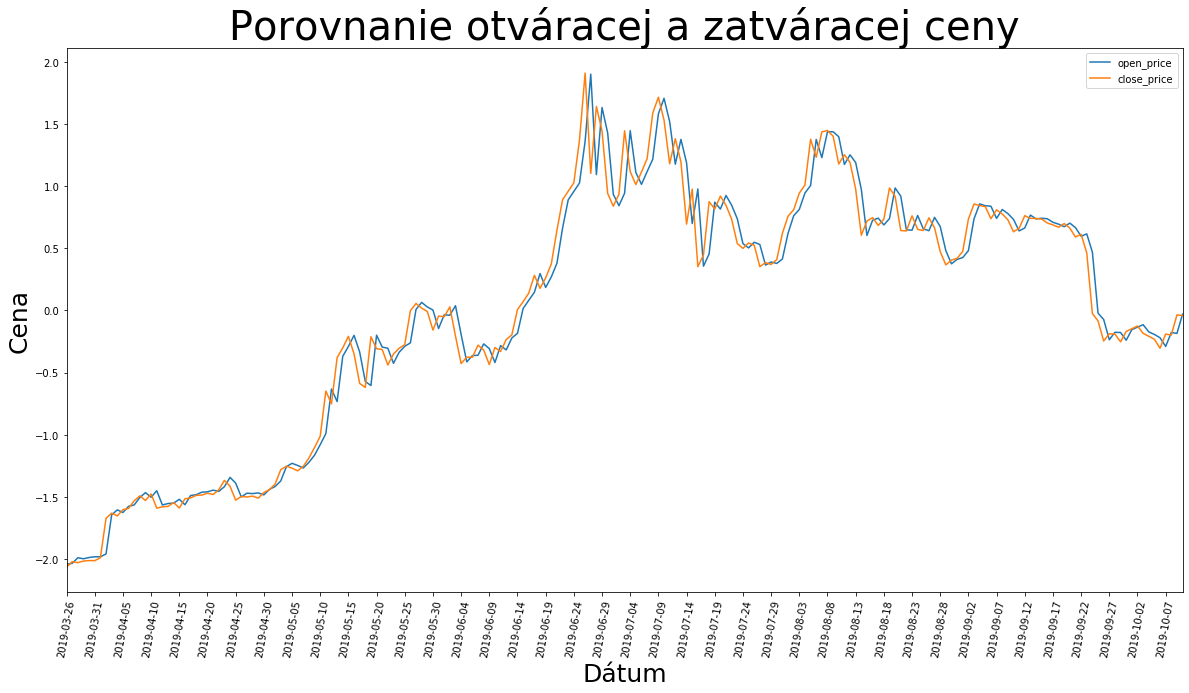

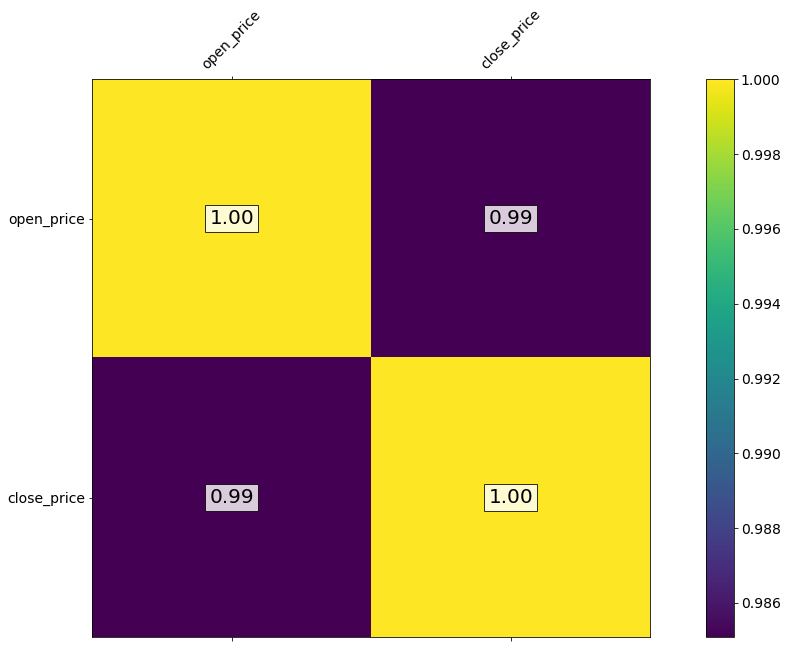

In [3]:
df = pd.read_csv("data.csv")
dff = PlotColumn(df, ['open_price', 'close_price'], scaler = StandardScaler(), title ='Porovnanie otváracej a zatváracej ceny',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dff)

# Porovnanie otváracej a zatváracej ceny - porušenie časovej závislosti

 - Porovnanie otváracej a zatváracej ceny - ceny sú normalizovane StandardScalerom
 - Použitý default Pearson
 - Dáta sú pred určením korelácie zamiešané

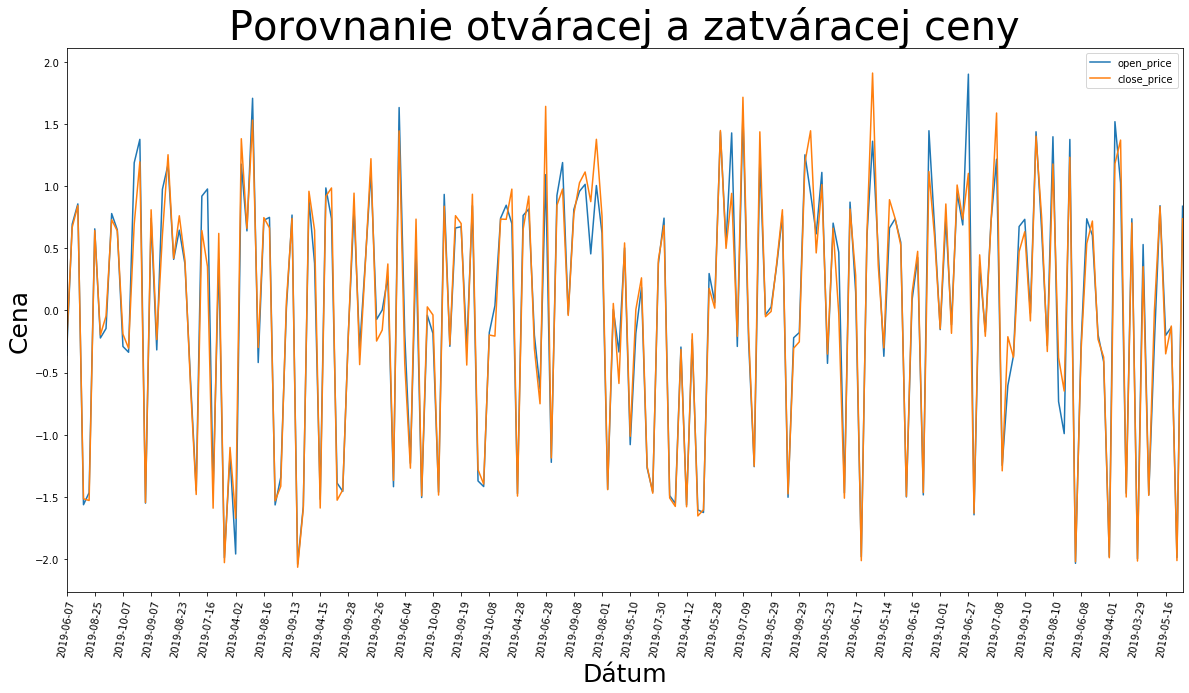

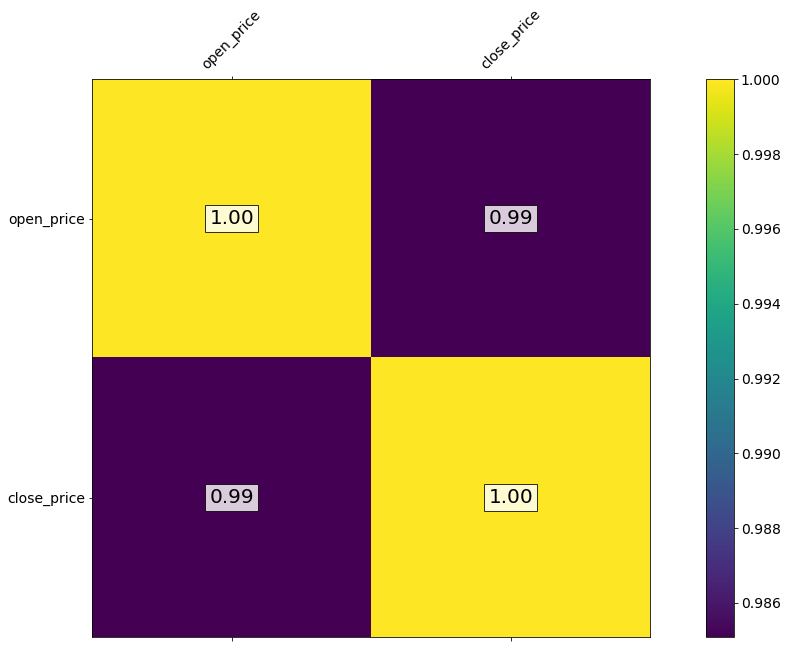

In [4]:
df = pd.read_csv("data.csv")
df = shuffle(df)
dff = PlotColumn(df, ['open_price', 'close_price'], scaler = StandardScaler(), title ='Porovnanie otváracej a zatváracej ceny',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dff)

## Výsledok dáta stále korelujú

 - dáta aj napriek odstráneniu časovej závislosti sú podobné nakoľko jednotlivé hodnoty sa líšia iba v "rozdiele" daného dňa => vzhladom na dáta zrejme zanedbateľná hodnota

# Porovnanie diferencie otváracej a zatváracej ceny

 - Ten istý postup ako pri samotnej cene
 - Porovnanie diferencie otváracej a zatváracej ceny - ceny sú normalizovane StandardScalerom
 - Použitý default Pearson
 - Dáta vizuálne korelujú ALE corelačný koeficient padol na hubu

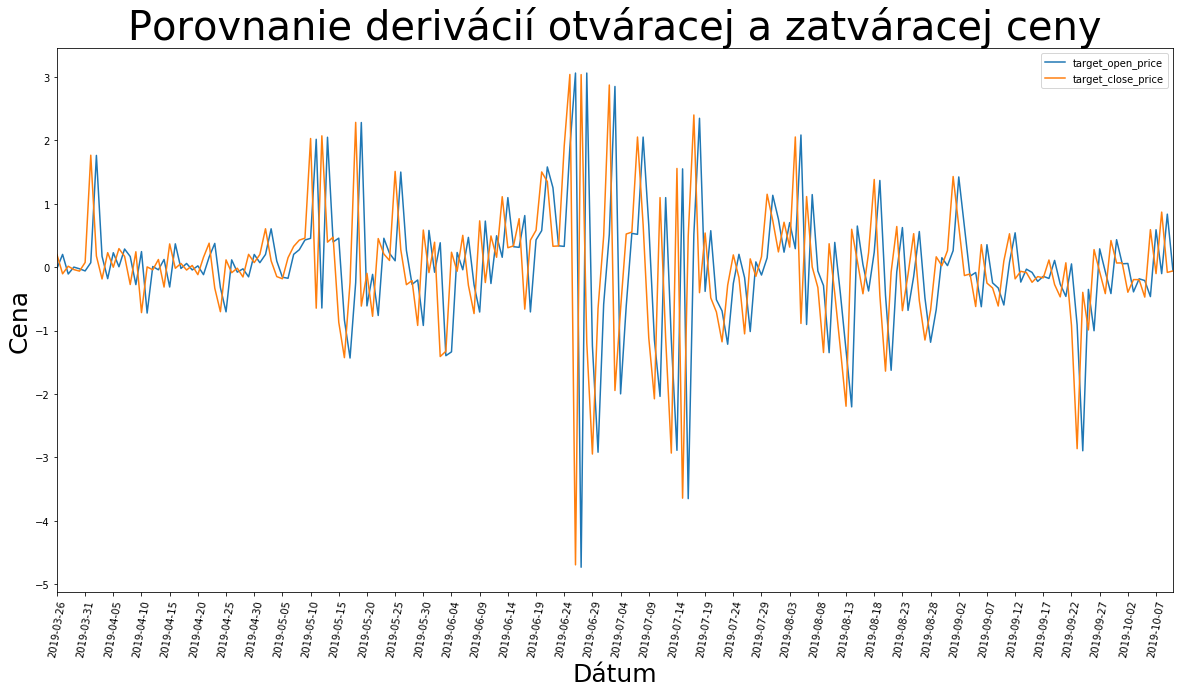

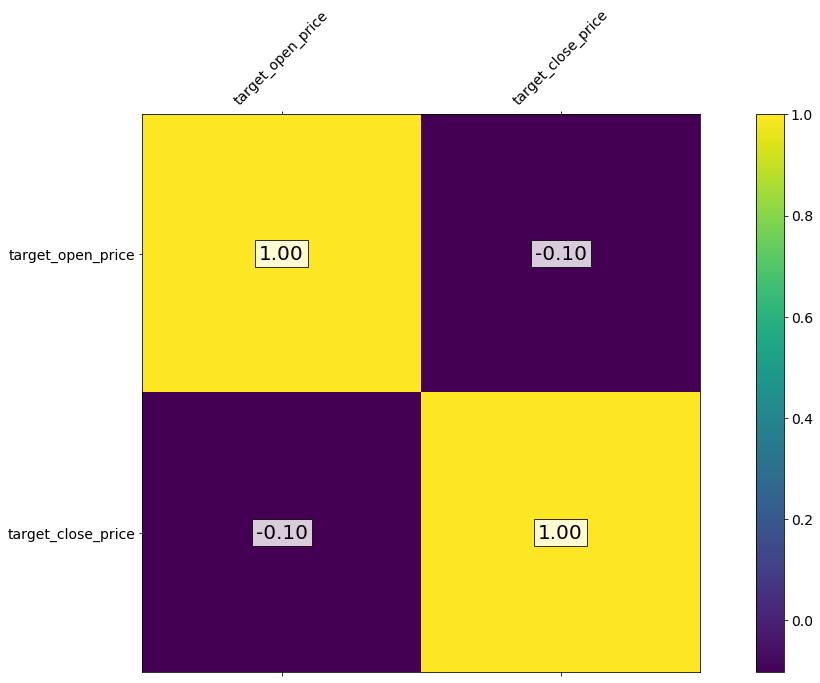

In [5]:
df = pd.read_csv("data.csv")
df['target_open_price'] = np.append(np.diff(df['open_price']), [0])
df['target_close_price'] = np.append(np.diff(df['close_price']), [0])
dff = PlotColumn(df, ['target_open_price', 'target_close_price'], scaler = StandardScaler(), title ='Porovnanie derivácií otváracej a zatváracej ceny',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dff)

## Prečo ?

# Porovnanie diferencie otváracej a zatváracej ceny - odstránenie časovej závislosti

 - Porovnanie diferencie otváracej a zatváracej ceny - ceny sú normalizovane StandardScalerom
 - Použitý default Pearson
 - Aktuálna vizualizácia ukazuje prečo korelácia padla (aspoň dúfam) dáta reprezentujú momentálne iba zmenu, ktorá je výrazne odlišná

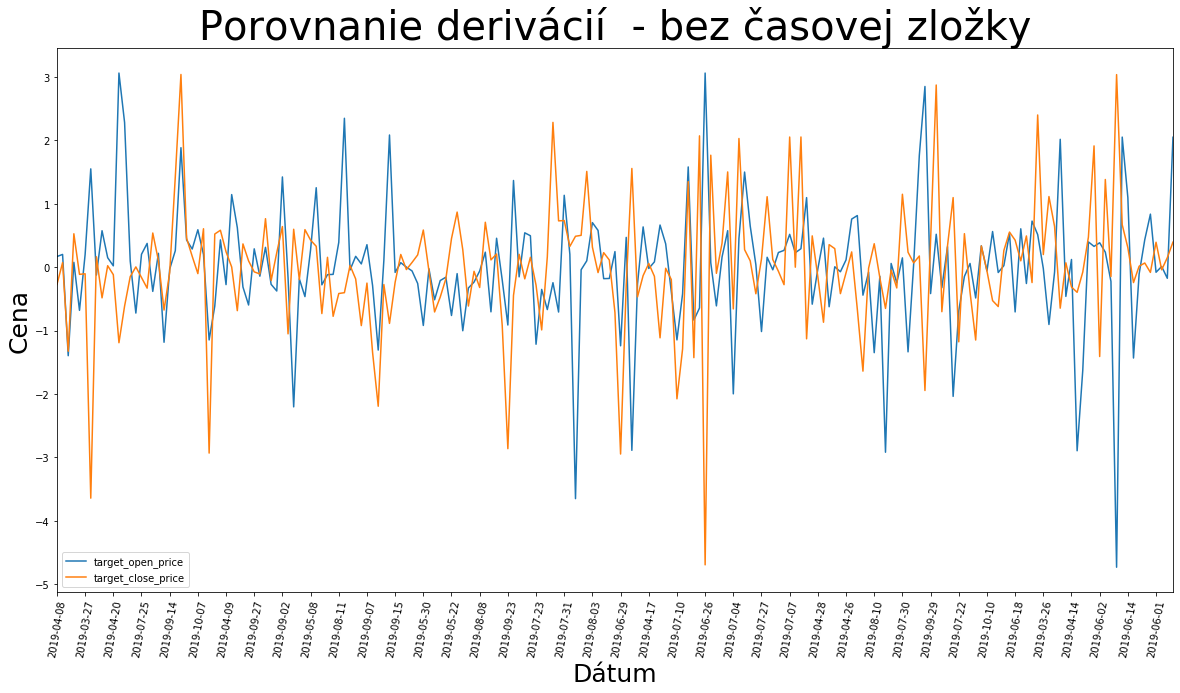

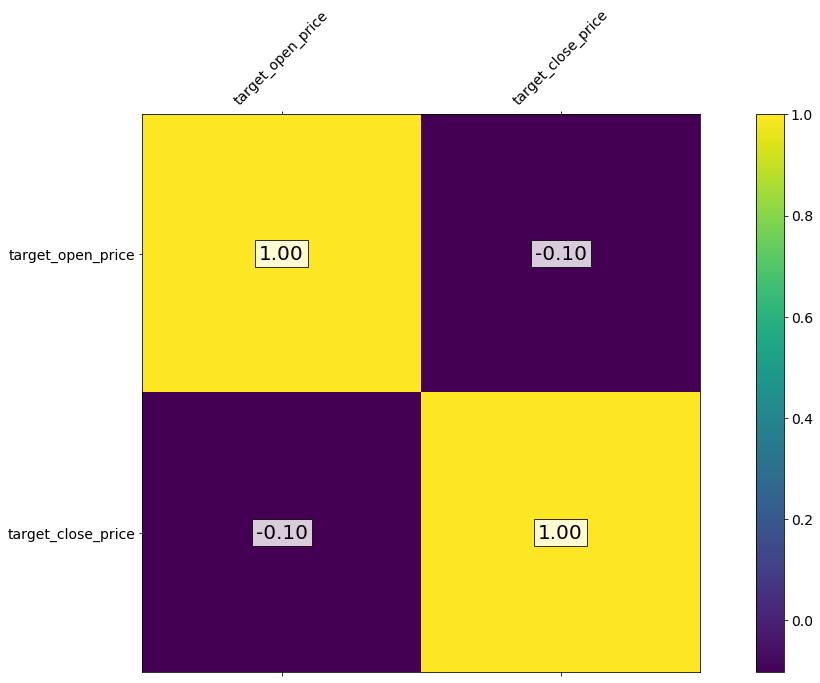

In [8]:
df = pd.read_csv("data.csv")
df['target_open_price'] = np.append(np.diff(df['open_price']), [0])
df['target_close_price'] = np.append(np.diff(df['close_price']), [0])
df = shuffle(df)
dff = PlotColumn(df, ['target_open_price', 'target_close_price'], scaler = StandardScaler(), title ='Porovnanie derivácií  - bez časovej zložky',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dff)

# Mám za to že o tomto sme sa bavili len sme to nevedeli zrejme pomenovať  v piatok 

# P.S.: Dúfam, že som nikde nespravil fatálnu logickú chybu :D